In [17]:
import torch
from transformers import AutoFeatureExtractor, Wav2Vec2ForPreTraining
from transformers.models.wav2vec2.modeling_wav2vec2 import _compute_mask_indices, _sample_negative_indices
from datasets import load_dataset

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-xls-r-300m")
model = Wav2Vec2ForPreTraining.from_pretrained("facebook/wav2vec2-xls-r-300m")

ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")
input_values = feature_extractor(ds[0]["audio"]["array"], return_tensors="pt", sampling_rate=16000).input_values  # Batch size 1

# compute masked indices
batch_size, raw_sequence_length = input_values.shape
sequence_length = model._get_feat_extract_output_lengths(raw_sequence_length).item()
mask_time_indices = _compute_mask_indices(
     shape=(batch_size, sequence_length), mask_prob=0.2, mask_length=2
 )
sampled_negative_indices = _sample_negative_indices(
     features_shape=(batch_size, sequence_length),
     num_negatives=model.config.num_negatives,
     mask_time_indices=mask_time_indices,
 )
mask_time_indices = torch.tensor(data=mask_time_indices, device=input_values.device, dtype=torch.long)
sampled_negative_indices = torch.tensor(
     data=sampled_negative_indices, device=input_values.device, dtype=torch.long
 )

with torch.no_grad():
   outputs = model(input_values, mask_time_indices=mask_time_indices)

In [12]:
min(min(input_values))

tensor(-5.4748)

In [14]:
min(ds[0]["audio"]["array"])

np.float64(-0.339111328125)

In [ ]:
import torch
import librosa
from datasets import load_dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

LANG_ID = "nl"
MODEL_ID = "jonatasgrosman/wav2vec2-large-xlsr-53-dutch"
SAMPLES = 10

test_dataset = load_dataset("common_voice", LANG_ID, split=f"test[:{SAMPLES}]")

processor = Wav2Vec2Processor.from_pretrained(MODEL_ID)
model = Wav2Vec2ForCTC.from_pretrained(MODEL_ID)

# Preprocessing the datasets.
# We need to read the audio files as arrays
def speech_file_to_array_fn(batch):
    speech_array, sampling_rate = librosa.load(batch["path"], sr=16_000)
    batch["speech"] = speech_array
    batch["sentence"] = batch["sentence"].upper()
    return batch

test_dataset = test_dataset.map(speech_file_to_array_fn)
inputs = processor(test_dataset["speech"], sampling_rate=16_000, return_tensors="pt", padding=True)

# with torch.no_grad():
#     logits = model(inputs.input_values, attention_mask=inputs.attention_mask).logits

# predicted_ids = torch.argmax(logits, dim=-1)
# predicted_sentences = processor.batch_decode(predicted_ids)

# for i, predicted_sentence in enumerate(predicted_sentences):
#     print("-" * 100)
#     print("Reference:", test_dataset[i]["sentence"])
#     print("Prediction:", predicted_sentence)


/opt/anaconda3/envs/whisperx/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x104fd96c0>>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/whisperx/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
/opt/anaconda3/envs/whisperx/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/whisperx/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <A0E0B741-848C-3144-924F-2971884DA4EF> /opt/anaconda3/envs/whisperx/lib

In [1]:
import numpy as np
from scipy.special import softmax
from sklearn.preprocessing import label_binarize
import pickle
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time
from moviepy.editor import VideoFileClip
from IPython.display import Video
from itertools import combinations
from collections import defaultdict
from elan_data import ELAN_Data
from scipy.signal import find_peaks
import torch, whisper
import os, librosa

from tqdm import tqdm

/home/eghaleb/anaconda3/envs/nlu/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# upload labels
buffer = 0.5
fps = 29.97
labels_path = "data/mm_data_vggish/27_labels_buffer_{}.pkl".format(buffer)

videos_path = "/home/eghaleb/data/{}_synced_pp{}.mp4"
SAMPLE_RATE = 16000


In [4]:
def get_predictions (results_details):
   predictions = results_details["preds"]
   predictions_n = np.array([float(pred[0]) for pred in predictions])
   predictions_g = np.array([float(pred[1]) for pred in predictions])
   predictions = np.column_stack((predictions_n, predictions_g))
   # apply softmax
   predictions = softmax(predictions, axis=1)
   return predictions
def get_class_predictions(results_details):
   predictions = results_details["preds"]
   predictions_n = np.array([float(pred[0]) for pred in predictions])
   predictions_g = np.array([float(pred[1]) for pred in predictions])
   predictions = np.column_stack((predictions_n, predictions_g))
   # apply softmax
   predictions = softmax(predictions, axis=1)
   results_details["gesture_preds"] = predictions[:, 1]
   results_details["gesture_preds"] = results_details["gesture_preds"].astype(float)
   results_details["neutral_preds"] = predictions[:, 0]
   results_details["neutral_preds"] = results_details["neutral_preds"].astype(float)
   return results_details, predictions
# best speech results

In [5]:
pairs_mappings = {}
for i in range(1, 150, 2):
   j = i + 1
   key = int(f"{i}{j}")
   value = f"{i:03}{j:03}"
   key = int(value)
   pairs_mappings[key] = value
   if i == 149 and j == 150:
      break
sample_pairs_mappings = {k: pairs_mappings[k] for k in list(pairs_mappings)}
sample_pairs_mappings


{1002: '001002',
 3004: '003004',
 5006: '005006',
 7008: '007008',
 9010: '009010',
 11012: '011012',
 13014: '013014',
 15016: '015016',
 17018: '017018',
 19020: '019020',
 21022: '021022',
 23024: '023024',
 25026: '025026',
 27028: '027028',
 29030: '029030',
 31032: '031032',
 33034: '033034',
 35036: '035036',
 37038: '037038',
 39040: '039040',
 41042: '041042',
 43044: '043044',
 45046: '045046',
 47048: '047048',
 49050: '049050',
 51052: '051052',
 53054: '053054',
 55056: '055056',
 57058: '057058',
 59060: '059060',
 61062: '061062',
 63064: '063064',
 65066: '065066',
 67068: '067068',
 69070: '069070',
 71072: '071072',
 73074: '073074',
 75076: '075076',
 77078: '077078',
 79080: '079080',
 81082: '081082',
 83084: '083084',
 85086: '085086',
 87088: '087088',
 89090: '089090',
 91092: '091092',
 93094: '093094',
 95096: '095096',
 97098: '097098',
 99100: '099100',
 101102: '101102',
 103104: '103104',
 105106: '105106',
 107108: '107108',
 109110: '109110',
 111112: '

In [6]:
def upload_models_small_result(results_path):
   with open(results_path, 'rb') as f:
      results = pickle.load(f)
   all_results_details = pd.DataFrame() 
   results_dict = defaultdict(list)
   speakers_mapping = {0: 'A', 1: 'B'}
   pairs_mapping = {4: 'pair04', 5: 'pair05', 6: 'pair06', 7: 'pair07', 8: 'pair08', 9: 'pair09', 10: 'pair10',
               11: 'pair11', 12: 'pair12', 13: 'pair13', 14: 'pair14', 15: 'pair15', 16: 'pair16', 17: 'pair17',
               18: 'pair18', 19: 'pair19', 20: 'pair20', 21: 'pair21', 22: 'pair22', 23: 'pair23', 24: 'pair24'}

   for fold in tqdm(range(5)):
      n_gpus, n_samples, num_seq = results[fold]['labels'].shape
      labels = results[fold]['labels'].reshape(n_gpus * n_samples* num_seq)
      preds = results[fold]['preds'].reshape(n_gpus * n_samples * num_seq, results[fold]['preds'].shape[-1])
      speaker_ID = results[fold]['speaker_ID'].reshape(n_gpus * n_samples * num_seq)
      pair_ID = results[fold]['pair_ID'].reshape(n_gpus * n_samples * num_seq)
      pair_speaker = [f"{pairs_mapping[int(pair)]}_{speakers_mapping[int(speaker)]}" for pair, speaker in zip(pair_ID, speaker_ID)]
      # repeat pair_speaker for each frame, 40 times
      start_frames = results[fold]['start_frames'].reshape(-1)
      end_frames = results[fold]['end_frames'].reshape(-1)
      folds = np.array([fold] * len(labels))
      results_dict['labels'].append(labels)
      results_dict['preds'].append(preds)
      results_dict['pair_speaker'].append(pair_speaker)
      results_dict['start_frames'].append(start_frames)
      results_dict['end_frames'].append(end_frames)
      results_dict['folds'].append(folds)
   # concatenate all the results
   for key in results_dict.keys():
      results_dict[key] = np.concatenate(results_dict[key])
      print(results_dict[key].shape)
      
   # convert to dataframe
   all_results_details = pd.DataFrame(results_dict, columns=['labels', 'start_frames', 'end_frames', 'folds'])
   # add preds
   all_results_details['preds'] = results_dict['preds'].tolist()
   all_results_details['pair_speaker'] = results_dict['pair_speaker']
   return all_results_details 

small_results_path = 'tb_logs/Appr_EarlyFusion_fold_4_lr_0.0001_subject_joint_False_gesture_unit_True_ft_speech_False_vggish_False_speech_buffer_0.0_offset_2_schedular_plateau_audio_encoder_False_skeleton_encoder_False_crf_False_bs_24_sc_False_/results.pkl'

small_results = upload_models_small_result(small_results_path)
small_results, all_preds = get_class_predictions(small_results)
small_gesture_results = small_results[small_results['labels'] == 1]


100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


(848800,)
(848800, 2)
(848800,)
(848800,)
(848800,)
(848800,)


In [7]:
small_gesture_results

,labels,start_frames,end_frames,folds,preds,pair_speaker,gesture_preds,neutral_preds
91,1.0,342.0,357.0,0,"[-1.109375, -4.75]",pair04_A,0.025565,0.974435
92,1.0,344.0,359.0,0,"[-1.15625, -4.78125]",pair04_A,0.025957,0.974043
93,1.0,346.0,361.0,0,"[-1.1875, -4.78125]",pair04_A,0.026759,0.973241
94,1.0,348.0,363.0,0,"[-1.2421875, -4.78125]",pair04_A,0.028221,0.971779
95,1.0,350.0,365.0,0,"[-1.390625, -4.5625]",pair04_A,0.040238,0.959762
...,...,...,...,...,...,...,...,...
848016,1.0,38432.0,38447.0,4,"[-0.53125, 0.28125]",pair22_A,0.692642,0.307358
848017,1.0,38434.0,38449.0,4,"[-0.515625, 0.357421875]",pair22_A,0.705379,0.294621
848018,1.0,38436.0,38451.0,4,"[-0.5390625, 0.306640625]",pair22_A,0.699665,0.300335
848019,1.0,38438.0,38453.0,4,"[-0.66796875, 0.0166015625]",pair22_A,0.664758,0.335242


In [8]:
def upload_models_result(results_path, pairs_mapping=pairs_mappings):
   with open(results_path, 'rb') as f:
      results = pickle.load(f)
   all_results_details = pd.DataFrame() 
   results_dict = {}
   speakers_mapping = {0: 'A', 1: 'B'}
   for fold in tqdm(range(5)):
      if fold == 2:
         continue
      n_gpus, n_samples, num_seq = results[fold]['labels'].shape
      labels = results[fold]['labels'].reshape(n_gpus * n_samples* num_seq)
      preds = results[fold]['preds'].reshape(n_gpus * n_samples * num_seq, results[fold]['preds'].shape[-1])
      speaker_ID = results[fold]['speaker_ID'].reshape(n_gpus * n_samples * num_seq)
      pair_ID = results[fold]['pair_ID'].reshape(n_gpus * n_samples * num_seq)
      pair_speaker = [f"{pairs_mapping[int(pair)]}_{speakers_mapping[int(speaker)]}" for pair, speaker in zip(pair_ID, speaker_ID)]
      # repeat pair_speaker for each frame, 40 times
      start_frames = results[fold]['start_frames'].reshape(-1)
      end_frames = results[fold]['end_frames'].reshape(-1)
      folds = np.array([fold] * len(labels))
      results_dict['labels'] = labels
      if fold == 0:
         results_dict['preds'] = preds 
      else:
         results_dict['preds'] = results_dict['preds'] +  preds
      results_dict['pair_speaker'] = pair_speaker
      results_dict['start_frames'] = start_frames
      results_dict['end_frames'] = end_frames
      results_dict['folds'] = folds 
      
   # convert to dataframe
   results_dict['preds'] = results_dict['preds']/5
   all_results_details = pd.DataFrame(results_dict, columns=['labels', 'start_frames', 'end_frames', 'folds'])
   # add preds
   all_results_details['preds'] = results_dict['preds'].tolist()
   all_results_details['pair_speaker'] = results_dict['pair_speaker']
   return all_results_details 

# results_path = 'tb_logs/Appr_Skeleton_fold_4_lr_5e-05_subject_joint_False_gesture_unit_True_ft_speech_False_vggish_False_speech_buffer_0.0_offset_2_schedular_plateau_audio_encoder_False_skeleton_encoder_True_crf_False_bs_40_sc_True_final/test_results.pkl'

results_path = 'tb_logs/Appr_EarlyFusion_fold_4_lr_0.0001_subject_joint_False_gesture_unit_True_ft_speech_False_vggish_False_speech_buffer_0.0_offset_2_schedular_plateau_audio_encoder_False_skeleton_encoder_False_crf_False_bs_24_sc_False_/test_results.pkl'


all_results = upload_models_result(results_path)
all_results, all_preds = get_class_predictions(all_results)
all_results['labels'] = all_results['gesture_preds'] > 0.5

100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


In [9]:
all_results[all_results['gesture_preds'] > 0.5].shape, all_results[all_results['gesture_preds'] < 0.5].shape

((956346, 8), (8221256, 8))

In [10]:
# remove duplicates in terms of start_frames and end_frames, and pair_speaker
all_results.drop_duplicates(subset=['start_frames', 'end_frames', 'pair_speaker', 'labels']).shape[0]-all_results.drop_duplicates(subset=['start_frames', 'end_frames', 'pair_speaker']).shape[0]

176337

In [11]:
gesture_results = all_results[all_results['gesture_preds'] > 0.55]
gesture_results.shape

(805377, 8)

In [12]:
gesture_results.drop_duplicates(subset=['start_frames', 'end_frames', 'pair_speaker', 'labels']).shape[0]-gesture_results.drop_duplicates(subset=['start_frames', 'end_frames', 'pair_speaker']).shape[0]

0

In [13]:
gesture_results.drop_duplicates(subset=['start_frames', 'end_frames', 'pair_speaker', 'labels'], inplace=True)

In [14]:
gesture_results.shape

(480021, 8)

In [15]:
# combine small_gesture_results with gesture_results
all_gesture_results = pd.concat([gesture_results, small_gesture_results])
# reset index
all_gesture_results.reset_index(drop=True, inplace=True)

In [16]:
all_gesture_results

,labels,start_frames,end_frames,folds,preds,pair_speaker,gesture_preds,neutral_preds
0,True,1986.0,2001.0,4,"[-1.01953125, -0.7476562261581421]",001002_A,0.567553,0.432447
1,True,1988.0,2003.0,4,"[-1.165624976158142, -0.6171875]",001002_A,0.633773,0.366227
2,True,1990.0,2005.0,4,"[-1.23046875, -0.5357421636581421]",001002_A,0.667018,0.332982
3,True,1992.0,2007.0,4,"[-1.2414062023162842, -0.4818359315395355]",001002_A,0.681260,0.318740
4,True,1994.0,2009.0,4,"[-1.1570312976837158, -0.4566894471645355]",001002_A,0.668264,0.331736
...,...,...,...,...,...,...,...,...
550169,1.0,38432.0,38447.0,4,"[-0.53125, 0.28125]",pair22_A,0.692642,0.307358
550170,1.0,38434.0,38449.0,4,"[-0.515625, 0.357421875]",pair22_A,0.705379,0.294621
550171,1.0,38436.0,38451.0,4,"[-0.5390625, 0.306640625]",pair22_A,0.699665,0.300335
550172,1.0,38438.0,38453.0,4,"[-0.66796875, 0.0166015625]",pair22_A,0.664758,0.335242


In [17]:
# save the results
all_gesture_results.to_pickle('data/segmented_gestures/segmented_gestures.pkl')

In [105]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('GroNLP/bert-base-dutch-cased')
# model = SentenceTransformer('NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers')
from torch.nn.functional import cosine_similarity
# use sklearn cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity as sklearn_cosine_similarity

No sentence-transformers model found with name GroNLP/bert-base-dutch-cased. Creating a new one with MEAN pooling.
Some weights of BertModel were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch


#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
 
# Sentences we want sentence embeddings for
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers')
model = AutoModel.from_pretrained('NetherlandsForensicInstitute/robbert-2022-dutch-sentence-transformers')

In [106]:
sentences = ["hond", "kat"]
embeddings = model.encode(sentences)
# compute cosine similarity
sklearn_cosine_similarity(embeddings[0].reshape(1, -1), embeddings[1].reshape(1, -1))

array([[0.84812313]], dtype=float32)

In [21]:
pairs_speakers = all_gesture_results['pair_speaker'].unique()

In [22]:
poses = {}
poses_path = 'data/selected_poses/poses_{}_synced_pp{}.npy'
for pair_speaker in tqdm(pairs_speakers, desc='Loading poses...', total=len(pairs_speakers)):
   pair, speaker = pair_speaker.split('_')
   poses[pair_speaker] = np.load(poses_path.format(pair, speaker))

Loading poses...: 100%|██████████| 136/136 [00:14<00:00,  9.70it/s]


In [23]:
# load poses 
from einops import rearrange
# load gesture results
for i , row in all_gesture_results.iterrows():
   start_frame = int(row['start_frames'])
   end_frame = int(row['end_frames'])
   pair_speaker = row['pair_speaker']
   pair = pair_speaker.split('_')[0]
   speaker = pair_speaker.split('_')[1]
   pose = poses[pair_speaker][start_frame:end_frame]
   # shape is (15, 27, 3) --> 15 T, 27 V, and 3 is C
   # target data shape should be C, T, V, M = data.shape
   pose = rearrange(pose, 't v c -> c t v')
   # expand dims
   pose = np.expand_dims(pose, axis=1)


<AxesSubplot: xlabel='gesture_preds', ylabel='Count'>

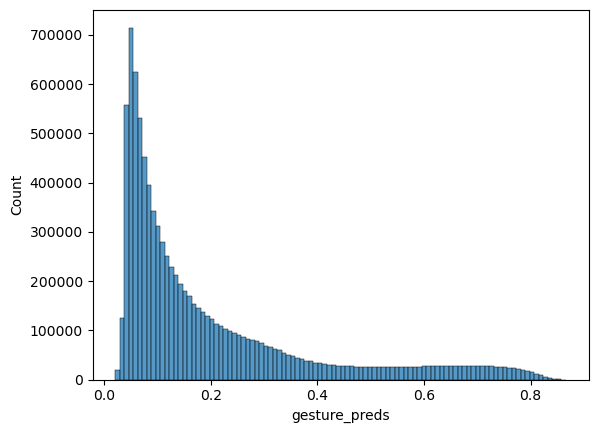

In [24]:
# plot the distribution of the predictions
sns.histplot(all_results["gesture_preds"], bins=100)

<AxesSubplot: xlabel='gesture_preds', ylabel='Count'>

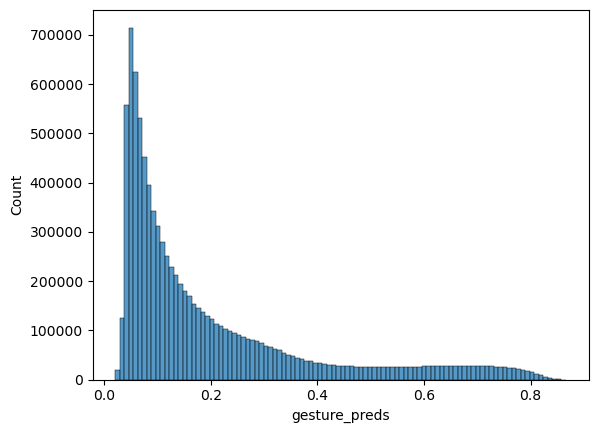

In [25]:
# plot the distribution of the predictions
sns.histplot(all_results["gesture_preds"], bins=100)

# ACROSS models, the samples labels are the same, but the features are different (Achievement)

In [26]:
# # calculate the accuracy for each class
# from sklearn.metrics import classification_report

# # plot the confusion matrix
# import numpy as np
# from sklearn.metrics import confusion_matrix, accuracy_score
# from sklearn.metrics import precision_recall_fscore_support
# from sklearn.preprocessing import label_binarize
# import seaborn as sns
# import matplotlib.pyplot as plt
# def print_performance_metrics(labels, predictions):
#    accuracy_report = classification_report(labels, np.argmax(predictions, axis=1), target_names=["Neutral", "Gesture"])
#    print(accuracy_report)
#    labels = np.array(labels)
#    labels = label_binarize(labels, classes=[0, 1]).ravel()  # Flatten the array if necessary

#    predictions = np.argmax(predictions, axis=1)
#    gesture_indices = np.where(labels == 1)[0]
#    non_gesture_indices = np.where(labels == 0)[0]
#    # gesture accuracy
#    overall_accuracy = np.sum(labels == predictions) / len(labels)
#    gesture_accuracy = np.sum(labels[gesture_indices] == predictions[gesture_indices]) / len(gesture_indices)
#    non_gesture_accuracy = np.sum(labels[non_gesture_indices] == predictions[non_gesture_indices]) / len(non_gesture_indices)
#    print("Overall accuracy: {:.2f}".format(overall_accuracy))
#    print("Gesture accuracy: {:.2f}".format(gesture_accuracy))
#    print("Non-gesture accuracy: {:.2f}".format(non_gesture_accuracy))
#    # calculate the micro and macro average
#    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="macro")
#    print("Precision: {:.2f}".format(precision))
#    print("Recall: {:.2f}".format(recall))
#    print("F1: {:.2f}".format(f1))
#    # calculate the micro and macro average
#    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="micro")
#    print("Precision: {:.2f}".format(precision))
#    print("Recall: {:.2f}".format(recall))
#    print("F1: {:.2f}".format(f1))
   
# speech_preds = get_predictions (all_results)
# labels = all_results["labels"]

# print_performance_metrics(labels, speech_preds)
# mm_preds = get_predictions (all_results)
# labels = all_results["labels"]
# print_performance_metrics(labels, mm_preds)
# # plot the confusion matrix

In [27]:
# convert speakers_gesture_percentages into dictionary
speakers_gesture_percentages = all_results.groupby('pair_speaker')['labels'].value_counts(normalize=True).reset_index(name='percentage')

In [28]:
speakers_gesture_percentages_dict = {}
for i, row in speakers_gesture_percentages.iterrows():
   if row['labels'] == 0:
      speakers_gesture_percentages_dict[row["pair_speaker"]] = row["percentage"]

In [29]:
videos_path = "/home/eghaleb/data/{}_synced_pp{}.mp4"
SAMPLE_RATE = 16000

In [30]:
unique_pair_speakers = all_results['pair_speaker'].unique()
import librosa
# load their audio
pairs_audio = {}
for pair_speaker in tqdm(unique_pair_speakers):
    pair, speaker = pair_speaker.split("_")
    video_path = videos_path.format(pair, speaker)
    audio_path = video_path.replace(".mp4", ".wav")
    pairs_audio[pair_speaker] = librosa.load(audio_path, sr=SAMPLE_RATE)[0]


100%|██████████| 98/98 [04:29<00:00,  2.75s/it]


In [31]:
all_results['speaker'] = all_results['pair_speaker'].apply(lambda x: x.split("_")[1])

In [32]:

def save_elan_files(pair_speaker, binar_gesture_predictions, gesture_predictions, min_gesture_predictions, fps):
   new_eaf = ELAN_Data.create_eaf("generated_elans/{}.gesture_prop_skeleton_speech.eaf".format(pair_speaker), audio="{}_synced_pp{}.mp4".format(pair, speaker),
                                    tiers=["gesture"],
                                    remove_default=True)

   i = 0
   while i < len(binar_gesture_predictions):
      label = binar_gesture_predictions[i]
      if label:
         print('start_frame=', i)
         start_frame = i
         start_ts = start_frame / fps
         for end_frame in range(i, len(binar_gesture_predictions)):
               first_frame_gesture_pred = gesture_predictions[start_frame]
               # print('Gesture prediction {:.2f}'.format(gesture_predictions[end_frame]))
               # print('Minimum prediction {:.2f}'.format(min_gesture_predictions[end_frame]))
               
               # print('Gesture prediction {:.2f}'.format(gesture_predictions[end_frame]))
               if not binar_gesture_predictions[end_frame] or gesture_predictions[end_frame] < 0.5:
                  i = end_frame+1
                  print('end_frame=', end_frame)
                  print('Gesture duration:', end_frame - start_frame)
                  end_ts = end_frame / fps
                  # convert to milliseconds
                  start_ts *= 1000
                  end_ts *= 1000
                  # print the gesture prediction which is float
                  max_gesture_pred = gesture_predictions[start_frame:end_frame].max()
   
                  # print('Gesture prediction {:.2f}'.format(first_frame_gesture_pred))
                  new_eaf.add_segment("skeleton speech gesture", start=start_ts, stop=end_ts,
                     annotation="Gesture prob_{:.2f}".format(max_gesture_pred))
                  # ed.add_annotation((start_ts, end_ts), "gesture", tier_name="gesture")
                  # print the times
                  # print('Start time:', start_ts)
                  # print('End time:', end_ts)
                  break
               else:
                  i += 1
      else:
         i += 1
   # ed.write()
   # new_eaf.save_ELAN(raise_error_if_unmodified=False)


In [33]:
pair_speaker = "119120_B"
all_pairs_speakers = all_results['pair_speaker'].unique()
for pair_speaker in tqdm(all_pairs_speakers, total=len(all_pairs_speakers)):
  pair_speaker = '119120_B'
  pair = pair_speaker.split("_")[0]
  speaker = pair_speaker.split("_")[1]
  poses = np.load("data/selected_poses/poses_{}_synced_pp{}.npy".format(pair, speaker), allow_pickle=True)
  pair_speaker_results = all_results[all_results['pair_speaker'] == pair_speaker]
  gesture_predictions = np.zeros(len(poses))
  min_gesture_predictions = np.zeros(len(poses))
  for frame, pose in tqdm(enumerate(poses), total=len(poses)):
      # get the rows where the frame is between start and end frames
        row = pair_speaker_results[(pair_speaker_results['start_frames'] <= frame) & (pair_speaker_results['end_frames'] >= frame)]
        # take the average of the gesture predictions
        gesture_predictions[frame] = row['gesture_preds'].mean()
        min_gesture_predictions[frame] = row['gesture_preds'].min()
  binar_gesture_predictions = gesture_predictions > 0.5
  # save_elan_files(pair_speaker, binar_gesture_predictions, gesture_predictions,min_gesture_predictions, fps)
  break

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/98 [01:19<?, ?it/s]


In [34]:

# find local maxima
def divide_segment(gesture_predictions, start_frame, end_frame):
    # find the local maxima
    average_gesture_predictions = gesture_predictions[start_frame:end_frame]
    min_peaks, min_peaks_dict = find_peaks(-average_gesture_predictions)
    peaks, peaks_dict = find_peaks(average_gesture_predictions)
    # print('Peaks:', peaks)
    sub_segments = defaultdict(list)
    # assert len(peaks) == len(min_peaks)+1 or len(peaks) < 5
    if len(peaks) == 0 or len(min_peaks) == 0 or len(peaks) == 1:
        sub_segments['start_frame'].append(start_frame)
        sub_segments['end_frame'].append(end_frame)
    else:
        for peak_id, peak in enumerate(peaks[:-1]):
            # print('Peak:', peak)
            # print('Peak ID:', peak_id)
            sub_segments['start_frame'].append(start_frame)
            if peak_id == len(peaks)-2:
                sub_segments['end_frame'].append(end_frame)
            else:
                sub_segments['end_frame'].append(min_peaks[peak_id])
            start_frame = min_peaks[peak_id]+1
    return sub_segments
            
           



def save_elan_files(pair_speaker, binar_gesture_predictions, gesture_predictions, min_gesture_predictions, fps):
   new_eaf = ELAN_Data.create_eaf("generated_elans/{}.gesture_final.eaf".format(pair_speaker), audio="{}_synced_pp{}.mp4".format(pair, speaker),
                                    tiers=["gesture"],
                                    remove_default=True)

   i = 0
   while i < len(binar_gesture_predictions):
      label = binar_gesture_predictions[i]
      if label:
         print('start_frame=', i)
         start_frame = i
         start_ts = start_frame / fps
         for end_frame in range(i, len(binar_gesture_predictions)):
               # print('Gesture prediction {:.2f}'.format(gesture_predictions[end_frame]))
               # print('Minimum prediction {:.2f}'.format(min_gesture_predictions[end_frame]))
               
               # print('Gesture prediction {:.2f}'.format(gesture_predictions[end_frame]))
               if not binar_gesture_predictions[end_frame]:
                  print('end_frame=', end_frame)
                  print('Duration:', end_frame - start_frame)
                  i = end_frame+1
                  average_gesture_predictions = gesture_predictions[start_frame:end_frame]
                  phases = divide_segment(average_gesture_predictions, 0, len(average_gesture_predictions))
                  phases['start_frame'] = np.array(phases['start_frame'])+start_frame
                  phases['end_frame'] = np.array(phases['end_frame'])+start_frame
                  num_phases = len(phases['start_frame'])   
                  for phase_id in range(num_phases):
                      print('Phase start frame:', phases['start_frame'][phase_id])
                      phase_start_frame = phases['start_frame'][phase_id]
                      phase_end_frame = phases['end_frame'][phase_id]
                      start_ts = phase_start_frame / fps * 1000
                      end_ts = phase_end_frame / fps * 1000
                      mean_preds = gesture_predictions[phase_start_frame:phase_end_frame].mean()
                      new_eaf.add_segment("skeleton-speech model", start=start_ts, stop=end_ts, annotation="probability {:.2f}".format(mean_preds))
                  break
                  
               else:
                  i += 1
      else:
         i += 1
   # ed.write()
#    new_eaf.save_ELAN(raise_error_if_unmodified=False)

In [36]:
# from speach import elan
# # merge two elan files
# elan_1 = eaf = elan.read_eaf('generated_elans/119120_B.gesture_prop_skeleton_speech.eaf')
# elan_2 = eaf = elan.read_eaf('generated_elans/119120_A.gesture_prop_skeleton_speech.eaf')
# for tier in elan_2:
#     print(tier)
    

In [37]:
save_elan_files(pair_speaker, binar_gesture_predictions, gesture_predictions,min_gesture_predictions, fps)

start_frame= 2288
end_frame= 2340
Duration: 52
Phase start frame: 2288
start_frame= 2600
end_frame= 2614
Duration: 14
Phase start frame: 2600
start_frame= 2770
end_frame= 2792
Duration: 22
Phase start frame: 2770
start_frame= 3396
end_frame= 3460
Duration: 64
Phase start frame: 3396
Phase start frame: 3439
start_frame= 4004
end_frame= 4010
Duration: 6
Phase start frame: 4004
start_frame= 4042
end_frame= 4104
Duration: 62
Phase start frame: 4042
start_frame= 4402
end_frame= 4444
Duration: 42
Phase start frame: 4402
start_frame= 4554
end_frame= 4574
Duration: 20
Phase start frame: 4554
start_frame= 4610
end_frame= 4642
Duration: 32
Phase start frame: 4610
start_frame= 5632
end_frame= 5726
Duration: 94
Phase start frame: 5632
start_frame= 6474
end_frame= 6550
Duration: 76
Phase start frame: 6474
Phase start frame: 6489
Phase start frame: 6513
start_frame= 7378
end_frame= 7446
Duration: 68
Phase start frame: 7378
start_frame= 7528
end_frame= 7584
Duration: 56
Phase start frame: 7528
start_

In [39]:
start_frame= 16282
end_frame= 16490+100

average_gesture_predictions = gesture_predictions[start_frame:end_frame]
minimum_predictions = min_gesture_predictions[start_frame:end_frame]
phases = divide_segment(average_gesture_predictions, 0, len(average_gesture_predictions))

In [40]:
min_peaks, min_peaks_dict = find_peaks(-average_gesture_predictions, distance=10)
peaks, peaks_dict = find_peaks(average_gesture_predictions, distance=10)

In [41]:
peaks

array([ 10,  48, 106, 136, 170, 204, 252, 266])

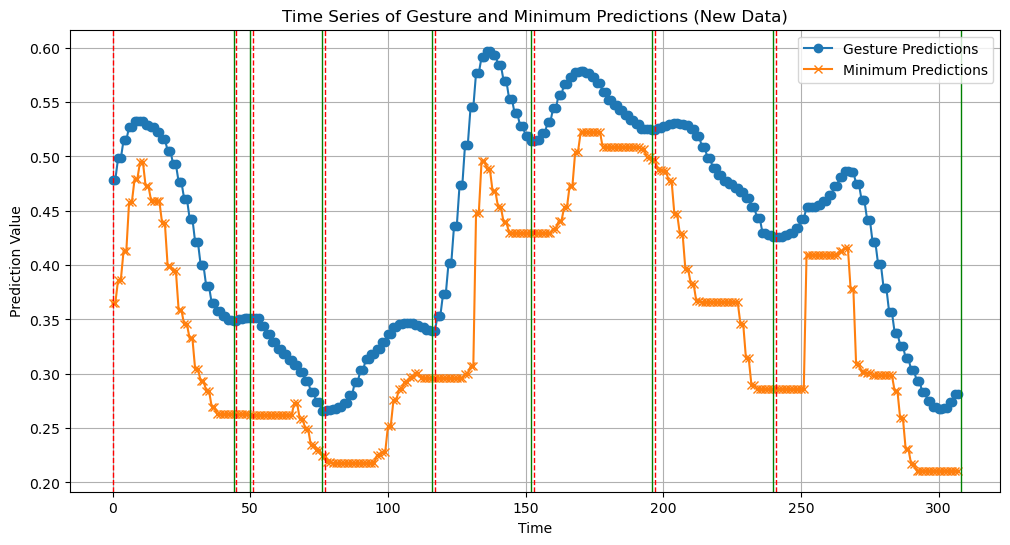

In [42]:
from moviepy.editor import VideoFileClip
 
def display_video_clip(pair, speaker, from_ts, to_ts, videos_path):
    pair_speaker = "{}_{}".format(pair, speaker)
    video_path = '/home/eghaleb/data/large_cabb/{}_synced_pp{}.mp4'.format(pair, speaker)
   #  video_path = videos_path.format(pair, speaker)
    clip = VideoFileClip(video_path, verbose=False).subclip(from_ts, to_ts)
    clip = clip.resize(width=500)
    display(clip.ipython_display(verbose=False, embed=True, write_logfile=False, ProgressBar=False, rd_kwargs=dict(logger=None)))
    
# fps = 29.97
# low_predictions = all_results[(all_results['gesture_preds'] > 0.5) & (all_results['speaker'] == 'B') & (all_results['gesture_preds'] < 0.55)].sample(1).iloc[0]
## choose a random row from dataframe low_predictions
# pair_speaker = low_predictions['pair_speaker']
# pair, speaker = pair_speaker.split("_")
# from_ts = low_predictions['start_frames']/fps 
# to_ts = low_predictions['end_frames']/fps+buffer
# display_video_clip(pair, speaker, from_ts, to_ts, videos_path)
# display(low_predictions)

from_ts = start_frame / fps
to_ts = end_frame / fps
pair_speaker = '119120_B'
pair = pair_speaker.split("_")[0]
speaker = pair_speaker.split("_")[1]
display_video_clip(pair, speaker, from_ts, to_ts, videos_path=videos_path)

# New data for Gesture Predictions and Minimum Predictions

# Time points for the new data
time_points_new = np.arange(len(average_gesture_predictions))

# Creating line plot for the new data
plt.figure(figsize=(12, 6))
plt.plot(time_points_new, average_gesture_predictions, label='Gesture Predictions', marker='o')
plt.plot(time_points_new, minimum_predictions, label='Minimum Predictions', marker='x')

timestamps = [(start / fps, end / fps) for start, end in zip(phases['start_frame'], phases['end_frame'])]

# Marking the phase boundaries on the plot
for start_ts, end_ts in timestamps:
    plt.axvline(x=start_ts * fps, linestyle='--', lw=1, color='red')
    plt.axvline(x=end_ts * fps, linestyle='-', lw=1, color='green')

plt.xlabel('Time')
plt.ylabel('Prediction Value')
plt.title('Time Series of Gesture and Minimum Predictions (New Data)')
plt.legend()
plt.grid(True)
plt.show()